In [ ]:
import io
help (io)

In [1]:
import sys
import pandas as pd

sys.path.append('src/Data processing scripts')
from CSV_module import CSVReader
from PreProcess_module import PreProcessor


from SQL_module import SQLManager  

from Logging_module import LoggerSetup  


In [57]:
file_urls = [
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_errors.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_failures.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_machines.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_maint.csv",
    "https://raw.githubusercontent.com/JakobRask/predictive-maintenance/main/data/raw/PdM_telemetry.csv"
    
]

csv_reader = CSVReader(file_urls, 'csv_reader_log.log')
dataframes = csv_reader.read_csv_files()


df1 = dataframes.get('PdM_errors')
df2 = dataframes.get('PdM_failures')
df3 = dataframes.get('PdM_machines')
df4 = dataframes.get('PdM_maint')
df5 = dataframes.get('PdM_telemetry')

preprocessor_df1 = PreProcessor(df1)
cleaned_df1 = preprocessor_df1.clean_data()  

preprocessor_df2 = PreProcessor(df2)
cleaned_df2 = preprocessor_df2.clean_data() 

preprocessor_df3 = PreProcessor(df3) 
cleaned_df3 = preprocessor_df3.clean_data() 

preprocessor_df4 = PreProcessor(df4) 
cleaned_df4 = preprocessor_df4.clean_data() 

preprocessor_df5 = PreProcessor(df5) 
cleaned_df5 = preprocessor_df5.clean_data() 

In [55]:
cleaned_df1.dtypes
print(type(cleaned_df1['errorID'].iloc[-1]))  
cleaned_df4['comp'].unique()
cleaned_df1['errorID'].unique()
cleaned_df3['model'].unique()

<class 'str'>


array(['model3', 'model4', 'model2', 'model1'], dtype=object)

In [23]:
### 
# Calculates how much time has passed since a certain machine or component 
# last failed. 
# It measures the time in hours between each failure of a component, 
# helping us understand how often it fails and how reliable it is. 
# NaN means that there is no data available for the "time since last failure" 
# because it’s the first failure recorded for that machine or component.
###

df2['date'] = df2['date'].astype(str)
df2['time'] = df2['time'].astype(str)
df2['datetime'] = pd.to_datetime(df2['date'] + ' ' + df2['time'])
df2 = df2.drop(columns=['date', 'time'])



df2 = df2.sort_values(by=['machineID', 'datetime'])
df2['time_since_last_failure'] = df2.groupby(['machineID', 'failure'])['datetime'].diff().dt.total_seconds() / 3600  
print(df2.head())

   machineID failure            datetime  time_since_last_failure
0          1   comp4 2015-01-05 06:00:00                      NaN
1          1   comp1 2015-03-06 06:00:00                      NaN
2          1   comp2 2015-04-20 06:00:00                      NaN
3          1   comp4 2015-06-19 06:00:00                   3960.0
4          1   comp4 2015-09-02 06:00:00                   1800.0


In [25]:
# Tracks how many times each specific component has failed over time 
# for each machine. 

df2= df2.sort_values(by=['machineID', 'datetime'])

df2['component_failure_count'] = df2.groupby(['machineID', 'failure']).cumcount() + 1
df2

,machineID,failure,datetime,time_since_last_failure,component_failure_count
0,1,comp4,2015-01-05 06:00:00,NaN,1
1,1,comp1,2015-03-06 06:00:00,NaN,1
2,1,comp2,2015-04-20 06:00:00,NaN,1
3,1,comp4,2015-06-19 06:00:00,3960.0,2
4,1,comp4,2015-09-02 06:00:00,1800.0,3
...,...,...,...,...,...
756,99,comp3,2015-11-29 06:00:00,2160.0,6
757,99,comp4,2015-12-14 06:00:00,1080.0,5
758,100,comp1,2015-02-12 06:00:00,NaN,1
759,100,comp1,2015-09-10 06:00:00,5040.0,2


In [58]:
cleaned_df1.columns

Index(['machineID', 'errorID', 'date', 'time'], dtype='object')

In [61]:
cleaned_df1['date'] = cleaned_df1['date'].astype(str)
cleaned_df1['time'] = cleaned_df1['time'].astype(str)
cleaned_df1['datetime'] = pd.to_datetime(cleaned_df1['date'] + ' ' + cleaned_df1['time'])
df1 = df1.drop(columns=['date', 'time'])

# Tracks how many times each specific component has had an error over 
# time for each machine. This feature can help identify components 
# that are prone to repeated errors, potentially signaling the need 
# for replacement or more frequent maintenance.

cleaned_df1= cleaned_df1.sort_values(by=['machineID', 'datetime'])

cleaned_df1['component_error_count'] = cleaned_df1.groupby(['machineID', 'errorID']).cumcount() + 1
cleaned_df1

,machineID,errorID,date,time,datetime,component_error_count
0,1,error1,2015-01-03,07:00,2015-01-03 07:00:00,1
1,1,error3,2015-01-03,20:00,2015-01-03 20:00:00,1
2,1,error5,2015-01-04,06:00,2015-01-04 06:00:00,1
3,1,error4,2015-01-10,15:00,2015-01-10 15:00:00,1
4,1,error4,2015-01-22,10:00,2015-01-22 10:00:00,2
...,...,...,...,...,...,...
3914,100,error2,2015-11-21,08:00,2015-11-21 08:00:00,6
3915,100,error1,2015-12-04,02:00,2015-12-04 02:00:00,11
3916,100,error2,2015-12-08,06:00,2015-12-08 06:00:00,7
3917,100,error3,2015-12-08,06:00,2015-12-08 06:00:00,7


C:\Users\Hanss\AppData\Local\Temp\ipykernel_31544\4000269375.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  errors_resampled = cleaned_df1.set_index('datetime').groupby('errorID').resample('M').sum()['component_error_count'].unstack()


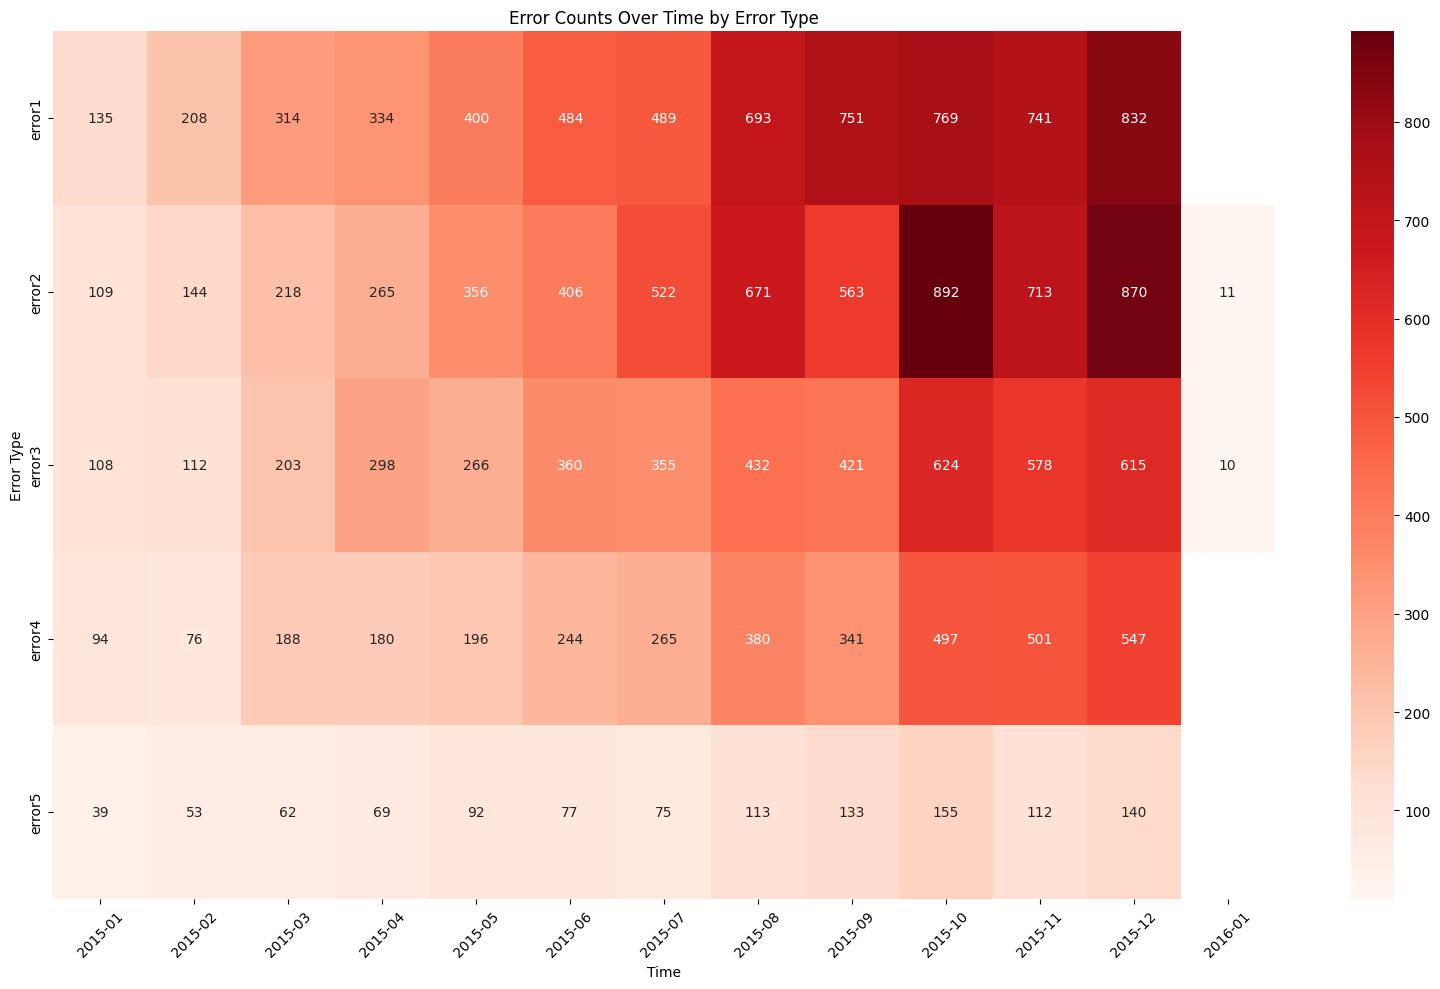

In [65]:
errors_resampled = cleaned_df1.set_index('datetime').groupby('errorID').resample('M').sum()['component_error_count'].unstack()


errors_resampled.columns = errors_resampled.columns.strftime('%Y-%m')


plt.figure(figsize=(16, 10))

sns.heatmap(errors_resampled, cmap="Reds", annot=True, cbar=True, fmt='g')


plt.title('Error Counts Over Time by Error Type')
plt.xlabel('Time')
plt.ylabel('Error Type')


plt.xticks(rotation=45)

plt.tight_layout()  
plt.show()

In [17]:
#Show which components failed during each event. This allows tracking
# of failures by component to see patterns across components.


components = cleaned_df2['failure'].unique()  

for component in components:
    cleaned_df2[f'failure_{component}'] = (cleaned_df2['failure'] == component).astype(int)
    

cleaned_df2

,machineID,failure,date,time,failure_comp4,failure_comp1,failure_comp2,failure_comp3
0,1,comp4,2015-01-05,06:00,1,0,0,0
1,1,comp1,2015-03-06,06:00,0,1,0,0
2,1,comp2,2015-04-20,06:00,0,0,1,0
3,1,comp4,2015-06-19,06:00,1,0,0,0
4,1,comp4,2015-09-02,06:00,1,0,0,0
...,...,...,...,...,...,...,...,...
756,99,comp3,2015-11-29,06:00,0,0,0,1
757,99,comp4,2015-12-14,06:00,1,0,0,0
758,100,comp1,2015-02-12,06:00,0,1,0,0
759,100,comp1,2015-09-10,06:00,0,1,0,0


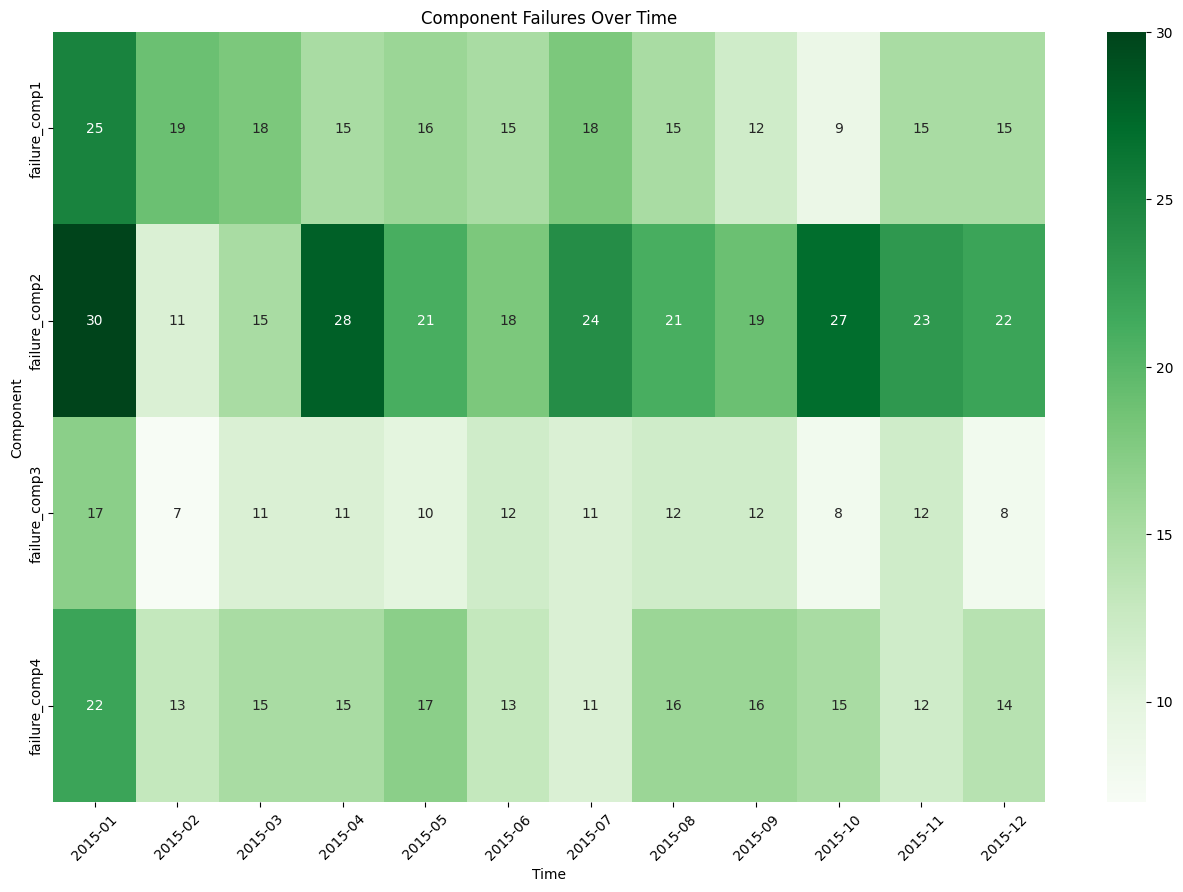

In [51]:

cleaned_df2['date'] = pd.to_datetime(cleaned_df2['date'])


heatmap_data = cleaned_df2[['date', 'failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4']].set_index('date')

heatmap_data_resampled = heatmap_data.resample('MS').sum() 

plt.figure(figsize=(16, 10))

heatmap_data_resampled.index = heatmap_data_resampled.index.strftime('%Y-%m')

sns.heatmap(heatmap_data_resampled.T, cmap="Greens", cbar=True, annot=True)

plt.title('Component Failures Over Time')
plt.xlabel('Time')
plt.ylabel('Component')

plt.xticks(rotation=45)

plt.show()


In [13]:
#Calculate the maintenance interval to determine the days between 
# consecutive maintenance events for each component on each machine. 
# This feature helps us understand the maintenance history and can be used 
# to predict when the next maintenance or failure might occur. 

df4['date'] = pd.to_datetime(df4['date'])

df4 = df4.sort_values(by=['machineID', 'comp', 'date'])

df4['maintenance_interval'] = df4.groupby(['machineID', 'comp'])['date'].diff().dt.days
df4

,machineID,comp,date,time,maintenance_interval
3,1,comp1,2014-12-13,06:00,NaN
5,1,comp1,2015-01-05,06:00,23.0
7,1,comp1,2015-01-20,06:00,15.0
11,1,comp1,2015-03-06,06:00,45.0
12,1,comp1,2015-03-21,06:00,15.0
...,...,...,...,...,...
3268,100,comp4,2015-04-28,06:00,90.0
3271,100,comp4,2015-05-28,06:00,30.0
3277,100,comp4,2015-08-26,06:00,90.0
3282,100,comp4,2015-10-25,06:00,60.0


In [ ]:
cleaned_df3.head()
print(type(cleaned_df3['model'].iloc[-1])) 

In [45]:
cleaned_df5.columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'datetime'], dtype='object')

In [5]:
cleaned_df5['date'] = cleaned_df5['date'].astype(str)
cleaned_df5['time'] = cleaned_df5['time'].astype(str)
cleaned_df5['datetime'] = pd.to_datetime(cleaned_df5['date'] + ' ' + cleaned_df5['time'])
df5 = df5.drop(columns=['date', 'time'])

cleaned_df5 = cleaned_df5.sort_values(by=['machineID', 'datetime'])

window_size = '30D'


cleaned_df5['volt_rolling_mean'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['volt'].mean().reset_index(drop=True)
cleaned_df5['volt_rolling_std'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['volt'].std().reset_index(drop=True)

cleaned_df5['rotate_rolling_mean'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['rotate'].mean().reset_index(drop=True)
cleaned_df5['rotate_rolling_std'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['rotate'].std().reset_index(drop=True)

cleaned_df5['pressure_rolling_mean'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['pressure'].mean().reset_index(drop=True)
cleaned_df5['pressure_rolling_std'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['pressure'].std().reset_index(drop=True)

cleaned_df5['vibration_rolling_mean'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['vibration'].mean().reset_index(drop=True)
cleaned_df5['vibration_rolling_std'] = cleaned_df5.groupby('machineID').rolling(window=window_size, on='datetime')['vibration'].std().reset_index(drop=True)


cleaned_df5.head(30)

,machineID,volt,rotate,pressure,vibration,date,time,datetime,volt_rolling_mean,volt_rolling_std,rotate_rolling_mean,rotate_rolling_std,pressure_rolling_mean,pressure_rolling_std,vibration_rolling_mean,vibration_rolling_std
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01,06:00,2015-01-01 06:00:00,176.217853,NaN,418.504078,NaN,113.077935,NaN,45.087686,NaN
1,1,162.879223,402.747490,95.460525,43.413973,2015-01-01,07:00,2015-01-01 07:00:00,169.548538,9.431836,410.625784,11.141591,104.269230,12.457390,44.250829,1.183494
2,1,170.989902,527.349825,75.237905,34.178847,2015-01-01,08:00,2015-01-01 08:00:00,170.028993,6.721032,449.533798,67.849599,94.592122,18.934956,40.893502,5.874970
3,1,162.462833,346.149335,109.248561,41.122144,2015-01-01,09:00,2015-01-01 09:00:00,168.137453,6.665324,423.687682,75.770259,98.256232,17.109194,40.950662,4.798255
4,1,157.610021,435.376873,111.886648,25.990511,2015-01-01,10:00,2015-01-01 10:00:00,166.031967,7.448844,426.025520,65.826868,100.982315,16.021893,37.958632,7.875828
5,1,172.504839,430.323362,95.927042,35.655017,2015-01-01,11:00,2015-01-01 11:00:00,167.110779,7.167373,426.741827,58.903479,100.139769,14.478264,37.574696,7.106854
6,1,156.556031,499.071623,111.755684,42.753920,2015-01-01,12:00,2015-01-01 12:00:00,165.602958,7.663161,437.074655,60.321814,101.799186,13.926919,38.314585,6.776542
7,1,172.522781,409.624717,101.001083,35.482009,2015-01-01,13:00,2015-01-01 13:00:00,166.467935,7.504690,433.643413,56.684136,101.699423,12.896909,37.960513,6.353286
8,1,175.324524,398.648781,110.624361,45.482287,2015-01-01,14:00,2015-01-01 14:00:00,167.452001,7.615497,429.755120,54.291106,102.691083,12.425356,38.796266,6.450198
9,1,169.218423,460.850670,104.848230,39.901735,2015-01-01,15:00,2015-01-01 15:00:00,167.628643,7.201655,432.864675,52.122115,102.906797,11.734582,38.906813,6.091345


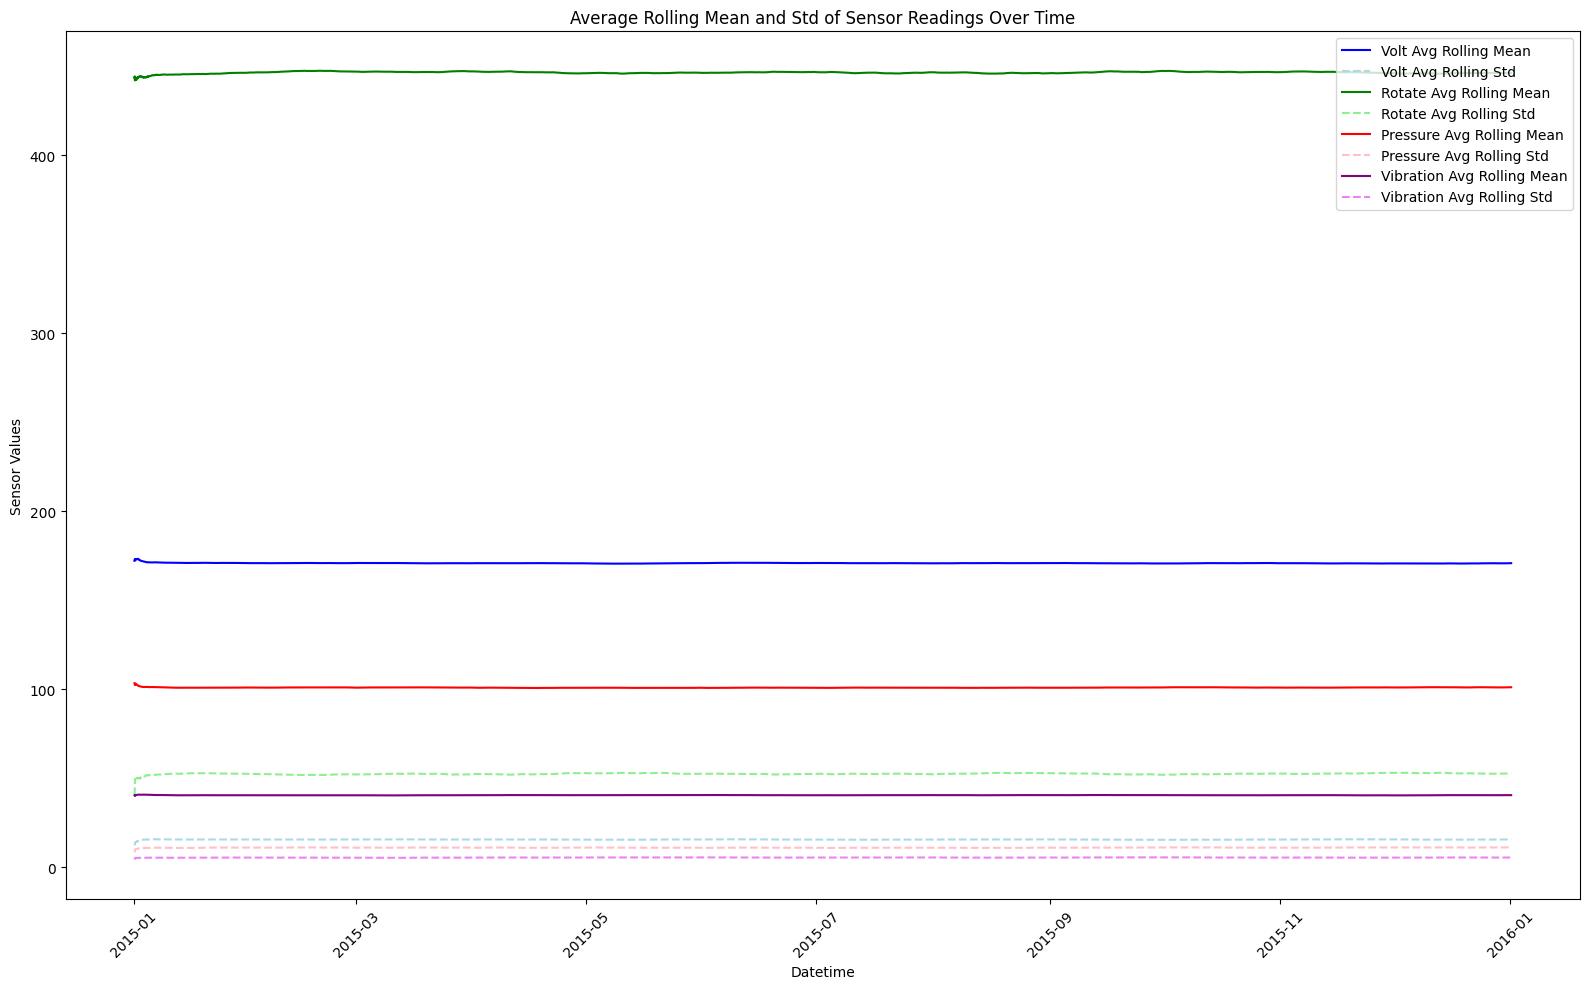

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt



avg_df = cleaned_df5.groupby('datetime').agg({
    'volt_rolling_mean': 'mean',
    'volt_rolling_std': 'mean',
    'rotate_rolling_mean': 'mean',
    'rotate_rolling_std': 'mean',
    'pressure_rolling_mean': 'mean',
    'pressure_rolling_std': 'mean',
    'vibration_rolling_mean': 'mean',
    'vibration_rolling_std': 'mean'
}).reset_index()

colors = {
    'volt_mean': 'blue',
    'volt_std': 'lightblue',
    'rotate_mean': 'green',
    'rotate_std': 'lightgreen',
    'pressure_mean': 'red',
    'pressure_std': 'pink',
    'vibration_mean': 'purple',
    'vibration_std': 'violet'
}
plt.figure(figsize=(16, 10))

sns.lineplot(x='datetime', y='volt_rolling_mean', data=avg_df, color=colors['volt_mean'], label='Volt Avg Rolling Mean')
sns.lineplot(x='datetime', y='volt_rolling_std', data=avg_df, color=colors['volt_std'], linestyle='--', label='Volt Avg Rolling Std')

sns.lineplot(x='datetime', y='rotate_rolling_mean', data=avg_df, color=colors['rotate_mean'], label='Rotate Avg Rolling Mean')
sns.lineplot(x='datetime', y='rotate_rolling_std', data=avg_df, color=colors['rotate_std'], linestyle='--', label='Rotate Avg Rolling Std')

sns.lineplot(x='datetime', y='pressure_rolling_mean', data=avg_df, color=colors['pressure_mean'], label='Pressure Avg Rolling Mean')
sns.lineplot(x='datetime', y='pressure_rolling_std', data=avg_df, color=colors['pressure_std'], linestyle='--', label='Pressure Avg Rolling Std')

sns.lineplot(x='datetime', y='vibration_rolling_mean', data=avg_df, color=colors['vibration_mean'], label='Vibration Avg Rolling Mean')
sns.lineplot(x='datetime', y='vibration_rolling_std', data=avg_df, color=colors['vibration_std'], linestyle='--', label='Vibration Avg Rolling Std')

plt.title('Average Rolling Mean and Std of Sensor Readings Over Time')
plt.xlabel('Datetime')
plt.ylabel('Sensor Values')

plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc='upper right')
plt.show()
